# Clean Hyperspectral Data Loading Pipeline

This notebook provides a clean, efficient pipeline for loading and preparing hyperspectral data for clustering and analysis.

## Key Improvements:
1. **Integer Coordinates**: x,y coordinates kept as integers (pixel positions)
2. **Global Normalization**: Spectral features normalized globally, not column-wise
3. **Valid Pixels Only**: Only processes non-masked pixels for efficiency
4. **Clean DataFrame**: Final result is a compact DataFrame ready for algorithms

## 1. Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

# Setup paths
base_dir = Path(r"C:\Users\meloy\PycharmProjects\Capstone")
import sys
sys.path.append(str(base_dir))
sys.path.append(str(base_dir / "wavelength_analysis"))

print("✓ Environment setup completed")
print(f"  Working directory: {base_dir}")
print(f"  Current time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Environment setup completed
  Working directory: C:\Users\meloy\PycharmProjects\Capstone
  Current time: 2025-09-19 16:07:33


In [2]:
# Import the improved data loading function
from concatenation_clustering import (
    load_masked_data,
    concatenate_hyperspectral_data_improved
)
from ground_truth_validation import extract_ground_truth_from_png

print("✓ Modules imported successfully")

✓ Modules imported successfully


## 2. Load and Prepare Data

In [3]:
# Define data paths
sample_name = "Lichens"
data_path = base_dir / "data" / "processed" / sample_name / "lichens_data_masked.pkl"
png_path = Path(r"C:\Users\meloy\Downloads\Mask_Manual.png")

print("Loading hyperspectral data...")
print(f"  Sample: {sample_name}")
print(f"  Data file: {data_path.name}")
print(f"  Ground truth: {png_path.name}")

# Load the raw hyperspectral data
full_data = load_masked_data(data_path)

print(f"\n✓ Data loaded successfully")
print(f"  Excitation wavelengths: {full_data['excitation_wavelengths']}")
print(f"  Number of excitations: {len(full_data['excitation_wavelengths'])}")

# Count total spectral bands
total_bands = sum(len(full_data['data'][str(ex)]['wavelengths']) 
                  for ex in full_data['excitation_wavelengths'])
print(f"  Total spectral bands: {total_bands}")

# Show spatial dimensions
sample_ex = str(full_data['excitation_wavelengths'][0])
sample_shape = full_data['data'][sample_ex]['cube'].shape
print(f"  Spatial dimensions: {sample_shape[0]} x {sample_shape[1]} pixels")
print(f"  Total pixels: {sample_shape[0] * sample_shape[1]:,}")

Loading hyperspectral data...
  Sample: Lichens
  Data file: lichens_data_masked.pkl
  Ground truth: Mask_Manual.png

✓ Data loaded successfully
  Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
  Number of excitations: 8
  Total spectral bands: 192
  Spatial dimensions: 1040 x 1392 pixels
  Total pixels: 1,447,680


In [4]:
# Optional: Crop data to working region (if needed)
print("Cropping data to working region...")

# Set cropping parameters (adjust as needed)
start_col = 1392 - 925  # Keep rightmost 925 columns
end_col = 1392

print(f"  Cropping to columns {start_col}:{end_col}")
print(f"  Original: {sample_shape[1]} columns -> New: {end_col - start_col} columns")

# Create cropped version
cropped_data = {
    'excitation_wavelengths': full_data['excitation_wavelengths'],
    'metadata': full_data.get('metadata', {}),
    'data': {}
}

# Crop each excitation wavelength's data
for ex in full_data['excitation_wavelengths']:
    ex_str = str(ex)
    original_cube = full_data['data'][ex_str]['cube']
    
    # Crop the spatial dimensions (keeping all spectral bands)
    cropped_cube = original_cube[:, start_col:end_col, :]
    
    # Copy metadata with cropped cube
    cropped_data['data'][ex_str] = {
        **full_data['data'][ex_str],
        'cube': cropped_cube
    }

# Use cropped data for processing
working_data = cropped_data
print(f"✓ Data cropped to shape: {cropped_cube.shape}")
print(f"  Working region: {cropped_cube.shape[0]} x {cropped_cube.shape[1]} pixels")

Cropping data to working region...
  Cropping to columns 467:1392
  Original: 1392 columns -> New: 925 columns
✓ Data cropped to shape: (1040, 925, 22)
  Working region: 1040 x 925 pixels


## 3. Create Clean Dataset with Improved Function

In [5]:
# Use the improved concatenation function on CROPPED data
print("Creating clean dataset with improved function...")
print("Key improvements:")
print("  - Integer coordinates (no normalization)")
print("  - Global spectral normalization (not column-wise)")
print("  - Only valid pixels processed")
print("  - Applied to CROPPED data region")
print("")

# Call the improved function on the CROPPED working_data
df, valid_mask, metadata = concatenate_hyperspectral_data_improved(
    working_data,  # This is the cropped version
    global_normalize=True,
    normalization_method='global_percentile'  # Options: 'global_percentile', 'global_minmax', 'global_standard', 'none'
)

print(f"\n✓ Clean dataset created from cropped region!")
print(f"  DataFrame shape: {df.shape}")
print(f"  Valid pixels: {metadata['n_valid_pixels']:,} / {metadata['n_total_pixels']:,} ({100*metadata['n_valid_pixels']/metadata['n_total_pixels']:.1f}%)")
print(f"  Coordinate columns: x (dtype: {df['x'].dtype}), y (dtype: {df['y'].dtype})")
print(f"  Spectral columns: {df.shape[1] - 2}")
print(f"  Normalization: {metadata['normalization_method']}")

# Show coordinate ranges
print(f"\nCoordinate ranges (in cropped region):")
print(f"  x: {df['x'].min()} to {df['x'].max()}")
print(f"  y: {df['y'].min()} to {df['y'].max()}")

# Show spectral data range
spectral_cols = [col for col in df.columns if col not in ['x', 'y']]
spectral_data = df[spectral_cols].values
print(f"\nSpectral data range: [{spectral_data.min():.4f}, {spectral_data.max():.4f}]")
print(f"Spectral data mean: {spectral_data.mean():.4f}, std: {spectral_data.std():.4f}")

print(f"\nNote: Coordinates are relative to the cropped region (0-{cropped_cube.shape[1]-1} width)")
print(f"Original full image was cropped from columns {start_col}-{end_col}")

Creating clean dataset with improved function...
Key improvements:
  - Integer coordinates (no normalization)
  - Global spectral normalization (not column-wise)
  - Only valid pixels processed
  - Applied to CROPPED data region

Starting improved data concatenation...
Found 8 excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Spatial dimensions: 1040 x 925
Finding valid pixels...
Found 223597 valid pixels out of 962000 total (23.2%)
Valid pixel coordinates range: x[17-759], y[131-809]
Extracting spectral data for valid pixels...
Extracted spectral data shape: (223597, 192)
Applying global normalization using method: global_percentile
  Used percentiles: P5=18.08, P95=959.14
Created DataFrame with shape: (223597, 194)
  - 223597 valid pixels (rows)
  - 194 features (columns): 2 integer coordinates + 192 spectral features
  - Coordinate types: x=int64, y=int64
  - Spectral data range: [0.0000, 1.0000]

✓ Clean dataset created from cropped region!
  DataFram

In [6]:
# Display the clean DataFrame
print("Sample of the clean dataset:")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

print(f"\nColumn names (showing first 10 spectral features):")
spectral_columns = [col for col in df.columns if col not in ['x', 'y']]
print(f"Coordinates: ['x', 'y']")
print(f"Spectral features (first 10): {spectral_columns[:10]}")
print(f"... and {len(spectral_columns) - 10} more spectral columns")

print(f"\nDataFrame memory usage: {df.memory_usage().sum() / 1024**2:.1f} MB")

Sample of the clean dataset:
Shape: (223597, 194)

First 5 rows:
     x    y  ex_310_em_420  ex_310_em_430  ex_310_em_440  ex_310_em_450  \
0  701  131       0.000000          0.000       0.021031       0.014323   
1  702  131       0.000000          0.000       0.021031       0.040315   
2  703  131       0.011808          0.016       0.059599       0.014323   
3  704  131       0.000000          0.000       0.000000       0.062115   
4  705  131       0.003423          0.000       0.000000       0.014323   

   ex_310_em_460  ex_310_em_470  ex_310_em_480  ex_310_em_490  ...  \
0       0.072176       0.115776       0.083076       0.133383  ...   
1       0.067984       0.122483       0.103199       0.148475  ...   
2       0.098168       0.044507       0.078884       0.144283  ...   
3       0.066307       0.093976       0.077207       0.111583  ...   
4       0.098168       0.072176       0.098168       0.089784  ...   

   ex_430_em_590  ex_430_em_600  ex_430_em_610  ex_430_em_620  

## 4. Your Clean Dataset is Ready!

**The DataFrame `df` contains properly processed data from the CROPPED region:**

- **x, y**: Integer pixel coordinates (no normalization applied)
  - **Important**: These coordinates are relative to the cropped region (0 to 924 for x-axis)
  - **Original cropping**: Columns {start_col} to {end_col} from full {sample_shape[1]}-column image
- **Spectral features**: All excitation-emission combinations, globally normalized
- **Only valid pixels**: No masked/invalid data included

**Usage for clustering/classification:**
```python
# Get features for clustering (spectral data only)
spectral_features = df[[col for col in df.columns if col not in ['x', 'y']]]

# Get coordinates for reconstruction (relative to cropped region)
coordinates = df[['x', 'y']]

# Run your algorithms on spectral_features
# Use coordinates to map results back to the CROPPED image space
```

**Summary:**
- Total pixels processed: {metadata['n_valid_pixels']:,}
- Spectral features: {len(spectral_cols)} 
- Coordinate range (cropped): x[{df['x'].min()}-{df['x'].max()}], y[{df['y'].min()}-{df['y'].max()}]
- Memory usage: {df.memory_usage().sum() / 1024**2:.1f} MB
- Working region: {cropped_cube.shape[0]} × {cropped_cube.shape[1]} pixels

## 5. Optional: ROI Visualization (if needed for analysis)

If you need to define ROI regions for specific analyses, you can visualize them on the cropped data.

Creating RGB-like visualization for ROI selection on CROPPED data...
Using cropped data shape: (1040, 925, 27)
  RGB channels: R=650.0nm, G=550.0nm, B=450.0nm


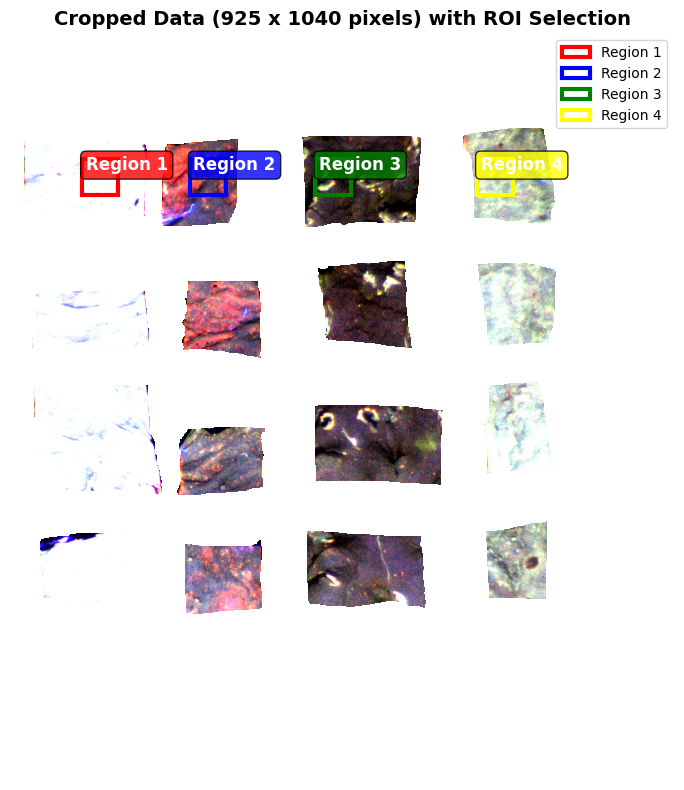


ROI Regions Summary (cropped data 925 x 1040):
  Region 1: Y[175:225], X[100:150] - 2500 pixels
  Region 2: Y[175:225], X[250:300] - 2500 pixels
  Region 3: Y[175:225], X[425:475] - 2500 pixels
  Region 4: Y[175:225], X[650:700] - 2500 pixels

✓ ROI visualization complete for cropped data region


In [9]:
# Optional: Define ROI regions for analysis (coordinates relative to cropped region)
# Adjust these coordinates based on your cropped region (0 to 924 for x-axis)

def visualize_roi_on_cropped_data(cropped_data, roi_regions=None):
    """Visualize ROI regions on the cropped hyperspectral data."""
    
    if roi_regions is None:
        # Default ROI regions (adjust these coordinates as needed)
        roi_regions = [
            {'name': 'Region 1', 'coords': (175, 225, 100, 150), 'color': 'red'},
            {'name': 'Region 2', 'coords': (175, 225, 250, 300), 'color': 'blue'},
            {'name': 'Region 3', 'coords': (175, 225, 425, 475), 'color': 'green'},
            {'name': 'Region 4', 'coords': (175, 225, 650, 700), 'color': 'yellow'},
        ]
    
    print("Creating RGB-like visualization for ROI selection on CROPPED data...")
    
    # Function to find closest wavelength index
    def find_closest_wavelength(wavelengths, target):
        wavelengths = np.array(wavelengths)
        idx = np.argmin(np.abs(wavelengths - target))
        return idx
    
    # Use excitation 365nm for good fluorescence across spectrum
    excitation_for_rgb = '365.0'
    
    if excitation_for_rgb in cropped_data['data']:
        cube_data = cropped_data['data'][excitation_for_rgb]['cube']
        wavelengths = cropped_data['data'][excitation_for_rgb]['wavelengths']
        
        print(f"Using cropped data shape: {cube_data.shape}")
        
        # Find indices for RGB-like wavelengths
        red_idx = find_closest_wavelength(wavelengths, 650)  # Red ~650nm
        green_idx = find_closest_wavelength(wavelengths, 550)  # Green ~550nm  
        blue_idx = find_closest_wavelength(wavelengths, 450)  # Blue ~450nm
        
        # Extract the RGB channels from CROPPED data
        red_channel = cube_data[:, :, red_idx]
        green_channel = cube_data[:, :, green_idx]
        blue_channel = cube_data[:, :, blue_idx]
        
        # Stack into RGB image
        rgb_image = np.stack([red_channel, green_channel, blue_channel], axis=2)
        
        # Normalize each channel independently
        for i in range(3):
            channel = rgb_image[:, :, i]
            vmin, vmax = np.percentile(channel[channel > 0], [2, 98]) if np.any(channel > 0) else (0, 1)
            rgb_image[:, :, i] = np.clip((channel - vmin) / (vmax - vmin + 1e-10), 0, 1)
        
        # Apply brightness enhancement
        brightness_factor = 2.5
        rgb_image = np.clip(rgb_image * brightness_factor, 0, 1)
        
        print(f"  RGB channels: R={wavelengths[red_idx]:.1f}nm, G={wavelengths[green_idx]:.1f}nm, B={wavelengths[blue_idx]:.1f}nm")
    else:
        # Fallback to first available excitation
        ex_str = str(cropped_data['excitation_wavelengths'][0])
        cube = cropped_data['data'][ex_str]['cube']
        # Create grayscale image from mean
        img = np.mean(cube, axis=2)
        img = (img - img.min()) / (img.max() - img.min() + 1e-10)
        rgb_image = np.stack([img, img, img], axis=2)
        print(f"  Using grayscale from excitation {ex_str}nm")
    
    # Create visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    ax.imshow(rgb_image)
    ax.set_title(f'Cropped Data ({rgb_image.shape[1]} x {rgb_image.shape[0]} pixels) with ROI Selection', 
                fontsize=14, fontweight='bold')
    
    # Draw ROI rectangles
    for roi in roi_regions:
        y_start, y_end, x_start, x_end = roi['coords']
        
        # Check if ROI coordinates are within cropped region
        if x_end <= rgb_image.shape[1] and y_end <= rgb_image.shape[0]:
            rect = plt.Rectangle(
                (x_start, y_start), 
                x_end - x_start, 
                y_end - y_start,
                linewidth=3, 
                edgecolor=roi['color'], 
                facecolor='none',
                label=roi['name']
            )
            ax.add_patch(rect)
            
            # Add label
            ax.text(x_start + 5, y_start + 15, roi['name'], 
                    color='white', fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor=roi['color'], alpha=0.8))
        else:
            print(f"  Warning: {roi['name']} coordinates exceed cropped region bounds")
    
    ax.axis('off')
    ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print ROI information for cropped region
    print(f"\nROI Regions Summary (cropped data {rgb_image.shape[1]} x {rgb_image.shape[0]}):")
    for roi in roi_regions:
        y_start, y_end, x_start, x_end = roi['coords']
        if x_end <= rgb_image.shape[1] and y_end <= rgb_image.shape[0]:
            print(f"  {roi['name']}: Y[{y_start}:{y_end}], X[{x_start}:{x_end}] - {(y_end-y_start)*(x_end-x_start)} pixels")
        else:
            print(f"  {roi['name']}: OUT OF BOUNDS for cropped region")
    
    return roi_regions

# Visualize ROI on the cropped data
roi_regions = visualize_roi_on_cropped_data(working_data)
print(f"\n✓ ROI visualization complete for cropped data region")

## 7. Run All Clustering Experiments

In [10]:
df

,x,y,ex_310_em_420,ex_310_em_430,ex_310_em_440,ex_310_em_450,ex_310_em_460,ex_310_em_470,ex_310_em_480,ex_310_em_490,...,ex_430_em_590,ex_430_em_600,ex_430_em_610,ex_430_em_620,ex_430_em_630,ex_430_em_640,ex_430_em_650,ex_430_em_660,ex_430_em_670,ex_430_em_680
0,701,131,0.000000,0.000000,0.021031,0.014323,0.072176,0.115776,0.083076,0.133383,...,0.223998,0.275175,0.392152,0.419933,0.354622,0.374605,0.285411,0.203527,0.188905,0.204990
1,702,131,0.000000,0.000000,0.021031,0.040315,0.067984,0.122483,0.103199,0.148475,...,0.257629,0.235208,0.374605,0.435043,0.448690,0.378504,0.314167,0.263965,0.187443,0.212788
2,703,131,0.011808,0.016000,0.059599,0.014323,0.098168,0.044507,0.078884,0.144283,...,0.252755,0.247881,0.393614,0.416034,0.364370,0.369731,0.321966,0.191342,0.176233,0.243982
3,704,131,0.000000,0.000000,0.000000,0.062115,0.066307,0.093976,0.077207,0.111583,...,0.198653,0.189880,0.368269,0.343411,0.311730,0.279075,0.287848,0.226435,0.168435,0.215225
4,705,131,0.003423,0.000000,0.000000,0.014323,0.098168,0.072176,0.098168,0.089784,...,0.201090,0.239108,0.295646,0.348285,0.305394,0.339512,0.243982,0.152350,0.144552,0.178670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223592,264,809,0.000000,0.000000,0.018515,0.018515,0.047023,0.055407,0.103199,0.083076,...,0.236671,0.243982,0.478909,0.480371,0.456489,0.475010,0.427244,0.350722,0.367294,0.526674
223593,265,809,0.000000,0.005939,0.040315,0.000000,0.077207,0.067984,0.100684,0.066307,...,0.246419,0.228872,0.451127,0.454052,0.452589,0.486707,0.457463,0.365832,0.367294,0.481346
223594,266,809,0.000000,0.007616,0.005939,0.033607,0.100684,0.113260,0.089784,0.055407,...,0.223998,0.236671,0.548120,0.505229,0.509128,0.500355,0.475010,0.377042,0.370706,0.510590
223595,267,809,0.016000,0.000000,0.062115,0.005939,0.096491,0.100684,0.093976,0.137575,...,0.247881,0.291747,0.441379,0.516439,0.474035,0.497918,0.419933,0.318067,0.380941,0.539347
